![imagenes](logo.png)

# Enunciado

La tabla [CT_58030.csv](https://github.com/scidatmath2020/Miscelanea/blob/main/Python/Estadistica%20y%20Ciencia%20de%20datos/preprocesado%20y%20graficacion%20CT_58030/CT_58030.csv) contiene 1,294 columnas con información, entre otras cosas, sobre la presencia de Aluminio, Azufre, Boro, Carbón, Titanio, Níquel, Cromo y Cobre en 1,755 observaciones, algunas de ellas repetidas.

Para cada uno de los elementos antes mencionados, existen normas que los valores de las observaciones deben cumplir. Esto es, esos valores deben estar en ciertos rangos:

Elemento|Mínimo|Máximo
:--|:--:|:--:
Aluminio|0.00|10.00
Azufre|0.00|0.05
Boro|0.00|10.00
Carbón|0.00|0.10
Titanio|0.00|10.00
Níquel|0.00|10.00
Cromo|0.00|10.00
Cobre|0.00|0.14

Verifica que la presencia de estos elementos en cada observación cumple con las normas.

---

# Solución

A continuación presentamos la solución propuesta.

In [1]:
### Librerías

from siuba import *
from siuba.dply.vector import *
from plotnine import *
import pandas as pd
import numpy as np
import os
import matplotlib

%matplotlib notebook

In [2]:
# Lectura del archivo

data = pd.read_csv("CT_58030.csv",low_memory=False)

In [3]:
# Vemos los nombres de las columnas
list(data.columns)

['MC4_PSQ - Fecha Produccion',
 'MC4_PSQ - Es peso bascula',
 'MC4_PSQ - Necesidad',
 'MC4_PSQ - Material',
 'MC4_PSQ - Colada',
 'MC4_PSQ - Cliente',
 'MC4_PSQ - Sociedad',
 'MC4_PSQ - Ruta Real',
 'MC4_PSQ - Dictamen',
 'MC4_PSQ - Resolucion',
 'MC4_PSQ - Material Entrada',
 'MC4_PSQ - Defecto Prioridad 1',
 'MC4_PSQ - Defecto Prioridad 2',
 'MC4_PSQ - Defecto Prioridad 3',
 'MC4_PSQ - Defecto Prioridad 4',
 'MC4_PSQ - Defecto Prioridad 5',
 'MC4_PSQ - Proveedor Planchon',
 'MC4_PSQ - Numero de Parte',
 'MC4_PSQ - Programa',
 'MC4_PSQ - ByPass Coilbox',
 'MC4_PSQ - Ancho Nominal Objetivo',
 'MC4_PSQ - Espesor Nominal Objetivo',
 'MC4_PSQ - Producto',
 'MC4_PSQ - Familia Calidad',
 'MC4_PSQ - Grado Generico',
 'MC4_PSQ - Norma',
 'MC4_PSQ - Grado',
 'MC4_PSQ - Subnorma',
 'MC4_PSQ - Tipo Acero',
 'MC4_PSQ - PRAM',
 'MC4_PSQ - PRO',
 'MC4_PSQ - Uso General',
 'MC4_PSQ - Clase',
 'MC4_PSQ - Estrategia',
 'MC4_PSQ - Mercado',
 'MC4_PSQ - Ruta Teorica',
 'MC4_PSQ - Barra Transferencia',
 

In [4]:
##### Observamos que los nombres de las columnas que nos interesan comienzan con "MC4_PSQ - " y termminan con el nombre 
##### del elemento de nuestro interés: Aluminio, Azufre, Boro, Carbon, Titanio, Niquel, Cromo y Cobre (no hay acentos)

# Preprocesamiento de la tabla

data_procesada = (data >> 
    # Selecciono las columnas de interés
    select(_.endswith(tuple(['Aluminio','Azufre', 'Boro', 'Carbon', 'Titanio', 'Niquel', 'Cromo', 'Cobre']))) >>
    # elimino filas duplicadas
    distinct() >>
    # Convierto a formato ordendo
    gather("elemento","valor",-_.id) >>
    # Elimino las letras "MC4_PSQ - " que venía cargando desde los nombres originales del dataframe
    mutate(elemento = _.elemento.str[10:])
    )

In [5]:
# Creamos un dataframe con los máximos por norma (los mínimos no nos interesan porque todos son 0)

normas = pd.DataFrame({"elemento":['Aluminio','Azufre', 'Boro', 'Carbon', 'Titanio', 'Niquel', 'Cromo', 'Cobre'],
          "max_norma":[10,0.05,10,0.10,10,10,10,0.14]})

In [6]:
(data_procesada >>
    group_by(_.elemento) >>
    summarize(minimo = _.valor.min(), maximo = _.valor.max()) >>
    inner_join(right=normas) >>
    filter((_.minimo < 0) | (_.maximo > _.max_norma)) >>
    summarize(total_fuera_de_rango = n(_.elemento))
    )

,total_fuera_de_rango
0,0


Observamos que ninguna observación salió del rango en ninguno de los elementos.

Hagamos un gráfico de caja para cada uno de los elementos

C:\Users\hp master\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 8 rows containing non-finite values.


<IPython.core.display.Javascript object>


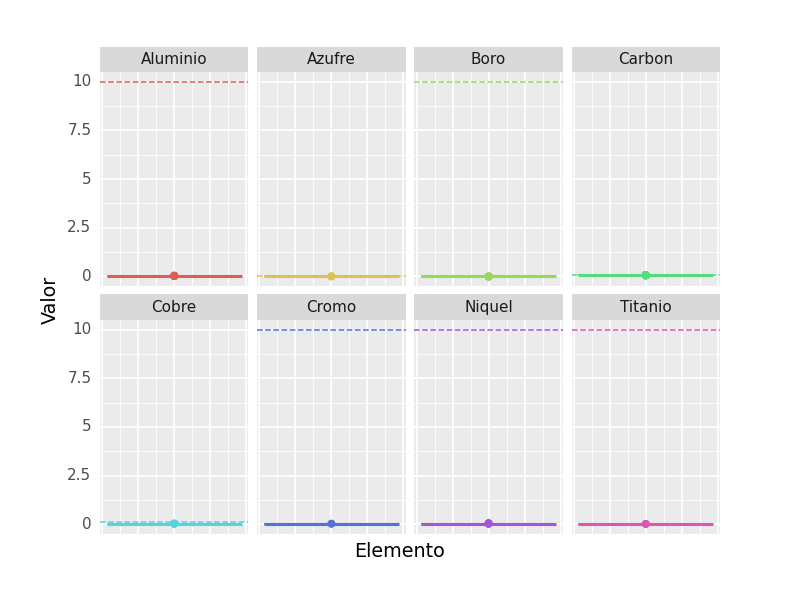

<ggplot: (-9223371937812476240)>

In [7]:
(ggplot() +
    geom_boxplot(data=data_procesada,mapping=aes(x=1,y="valor",color="elemento")) +
    theme(axis_text_x = element_blank(), axis_ticks_major=element_blank()) +
    geom_hline(data=normas,mapping=aes(yintercept="max_norma",color="elemento"),linetype="dashed") +
    scale_color_discrete(guide=False) +
    xlab("Elemento") +
    ylab("Valor") + 
    facet_wrap("elemento",nrow=2)
)

Se observa que claramente en Aluminio, Boro, Cromo, Níquel y Titanio se cumplen las normas. Para Azufre, Carbón y Cobre no es claro si se cumplen las normas. Para estos tres, veamos unas gráficas mejor ajustadas:

C:\Users\hp master\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 3 rows containing non-finite values.


<IPython.core.display.Javascript object>


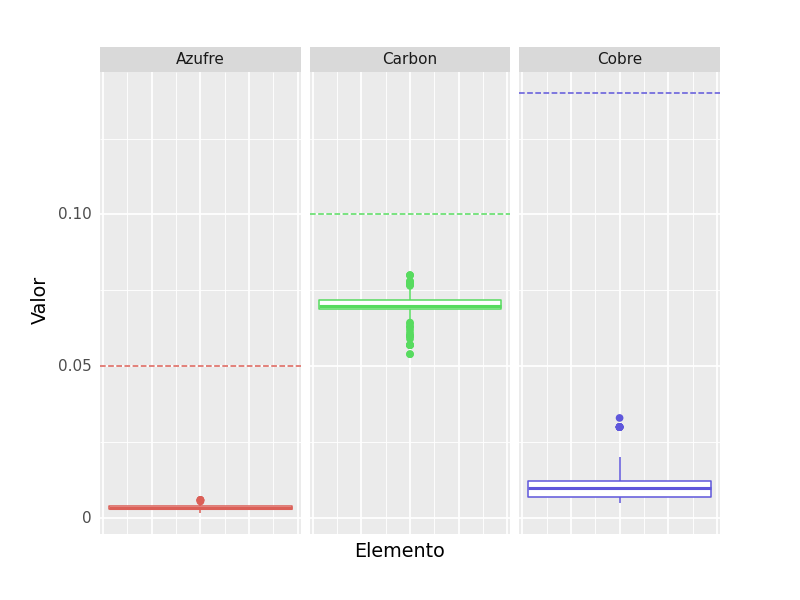

<ggplot: (-9223371937925378148)>

In [8]:
data_especiales = data_procesada >> filter(_.elemento.isin(["Azufre","Carbon","Cobre"]))
normas_especiales = normas >> filter(_.elemento.isin(["Azufre","Carbon","Cobre"]))

(ggplot() +
    geom_boxplot(data=data_especiales,mapping=aes(x=1,y="valor",color="elemento")) +
    theme(axis_text_x = element_blank(), axis_ticks_major=element_blank()) +
    geom_hline(data=normas_especiales,mapping=aes(yintercept="max_norma",color="elemento"),linetype="dashed") +
    scale_color_discrete(guide=False) +
    xlab("Elemento") +
    ylab("Valor") + 
    facet_wrap("elemento",ncol=3)
)

Ahora sí, se observa claramente que estos tres elementos cumplen la norma, tal como nuestro análisis previo dijo.